In [ ]:
!pip install fastai==2.7.14
!pip install wandb
!pip install numpy matplotlib librosa
!pip install fastbook==0.0.29

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install Pillow==9.4.0

In [ ]:
import sys
import torch
import wandb
import os, re, csv
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callback.all import *
from fastai.callback import *
from fastai.vision.all import *

from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### LIBRARY

In [ ]:
def _get_emotion(file_path):
    base_file_name = os.path.basename(file_path)
    file_name_split = base_file_name.split('_')[-1]
    return file_name_split

In [ ]:
def _generate_spectrogram_save_image(audio_file_path, destination_path):
    y, sr = librosa.load(audio_file_path)
    yt,_=librosa.effects.trim(y)
    y=yt
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
    emotion_dir = os.path.dirname(destination_path)
    if not os.path.isdir(emotion_dir):
        os.makedirs(emotion_dir)
    plt.savefig(destination_path)




<ipython-input-5-5602354661ef>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/emotion_detection_using_sound/data/Processed_Data_Iemocap/iemocap_audio/iemocap_audio/IEMOCAP_wav/Ses02F_script03_1_F030.wav'

## PREPROCESSING IEMOCAP Dataset. Some of the folders are not present in RAVDESS and TESS datasets. We will add approx 592 files from these emotions to "Processed_Data" folder. We will use this supplementary emotions to make it inline with SKAIG emotion recognition

2 new emotions to be added are "excited" and "frustrated". Couple of emotions which are removed from IEMOCAP are "fearful", "disgust" and "surprised".

#### Will be getting rid of these emotions from Training using RAVDESS as well as TESS.



In [ ]:
from concurrent.futures import ThreadPoolExecutor

In [ ]:
DATA_ROOT_PATH='/content/drive/MyDrive/emotion_detection_using_sound'
IEMOCAP_ROOT_FLDR = f"{DATA_ROOT_PATH}/data/Iemocap"
IEMOCAP_DATA = f"{IEMOCAP_ROOT_FLDR}/iemocap_audio/iemocap_audio/IEMOCAP_wav"
IEMOCAP_PROCESSED_FLDR = "/content/drive/MyDrive/Preprocessed_imeocap_data"
IEMOCAP_PENDING_PROCESSING_DOC = f"{IEMOCAP_ROOT_FLDR}/iemocap_trans_gcp.csv"

IEMOCAP_EMOTION_MAPPING = {
    "exc":"excited",
    "ang":"angry",
    "fru":"frustrated",
    "hap":"happy",
    "neu":"neutral",
    "sad":"sad"
}

In [ ]:
# File_name and emotion for faster emotion resolution
file_name_emotion_dict = {}
with open(IEMOCAP_PENDING_PROCESSING_DOC, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if IEMOCAP_EMOTION_MAPPING.get(row['emotion']):
            file_name_emotion_dict[row['title']] = row['emotion']


IEMOCAP_FILES=os.listdir(IEMOCAP_DATA)
for audio_file in IEMOCAP_FILES:
    audio_file_name = os.path.basename(audio_file)

    # There is an additional emotion category in IEMOCAP: oth; we are trying to get rid of it.
    if file_name_emotion_dict.get(os.path.splitext(audio_file_name)[0]):
        destination_emotion_folder = IEMOCAP_EMOTION_MAPPING[file_name_emotion_dict[os.path.splitext(audio_file_name)[0]]]
        destination_folder = destination_emotion_folder.lower()

        destination_save_path = f'{IEMOCAP_PROCESSED_FLDR}/{destination_emotion_folder}/{audio_file_name}.jpeg'
        # _generate_spectrogram_save_image(f"{IEMOCAP_DATA}/{audio_file}", destination_save_path)
        audio_file_path = f"{IEMOCAP_DATA}/{audio_file_name}"
        y, sr = librosa.load(audio_file_path)
        yt,_=librosa.effects.trim(y)
        y=yt
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
        librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
        emotion_dir = os.path.dirname(destination_save_path)
        print(destination_save_path)
        if not os.path.isdir(emotion_dir):
            os.makedirs(emotion_dir)
        plt.savefig(destination_save_path)


/content/drive/MyDrive/Preprocessed_imeocap_data/frustrated/Ses05M_impro01_M013.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F008.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_M003.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F000.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F020.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_M002.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F021.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F014.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F018.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/neutral/Ses05M_impro05_F011.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data/frustrated/Ses05M_impro05_M020.wav.jpeg
/content/drive/MyDrive/Preprocessed_imeocap_data

In [ ]:
# Temporarily removing those files which are already processed and jpeg image created.
# IEMOCAP_PROCESSED_FLDR_IN_OTHER_DRIVE = f"{DATA_ROOT_PATH}/data/Processed_Data"
IEMOCAP_PROCESSED_FLDR_IN_CURRENT_DRIVE = f"{IEMOCAP_PROCESSED_FLDR}"

PROCESSED_IEMOCAP_FILES = set()
for path, subdirs, files in os.walk(IEMOCAP_PROCESSED_FLDR_IN_CURRENT_DRIVE):
    for name in files:
        PROCESSED_IEMOCAP_FILES.add(name.replace('.wav.jpeg',''))
print(len(PROCESSED_IEMOCAP_FILES))

# We see that the files which are processed in current directory are also different.
# Lets remove all of them from the transcript file
fieldnames = ["_id", "activation", "dominance", "emotion", "end_time", "start_time", "title", "to_translate", "translated", "valence", ""]

with open(IEMOCAP_TRANSCRIPT_DOC, newline='') as inp, open(f'{IEMOCAP_ROOT_FLDR}/final_transcript_doc.csv', 'w') as out:
    writer = csv.DictWriter(out, fieldnames=fieldnames)

    for row in csv.DictReader(inp):
        if row['title'] not in PROCESSED_IEMOCAP_FILES:
            writer.writerow(row)



Streaming output truncated to the last 5000 lines.
{'_id': '62569ade1da7a5c1eaef70a7', 'activation': '2', 'dominance': '3.5', 'emotion': 'ang', 'end_time': '351.5675', 'start_time': '349.2', 'title': 'Ses04F_script01_1_M044', 'to_translate': ' I am thinking that way.', 'translated': 'Je pense de cette façon.', 'valence': '2.5', '': ''}
Ses04F_script01_1_F043
{'_id': '62569ade1da7a5c1eaef70a8', 'activation': '3', 'dominance': '3.5', 'emotion': 'ang', 'end_time': '355.113', 'start_time': '352.08', 'title': 'Ses04F_script01_1_F043', 'to_translate': " I don't understand you do I?", 'translated': 'je ne te comprends pas moi ?', 'valence': '1.5', '': ''}
Ses04F_script01_1_M045
{'_id': '62569ade1da7a5c1eaef70a9', 'activation': '3', 'dominance': '3.5', 'emotion': 'ang', 'end_time': '358.2534', 'start_time': '354.7078', 'title': 'Ses04F_script01_1_M045', 'to_translate': " No.  I'm a pretty tough guy.", 'translated': 'Non. Je suis un gars assez dur.', 'valence': '2.5', '': ''}
Ses04F_script01_1_

## PREPROCESSING RAVDESS AND TESS DATA SOURCE as per their emotion. This data would be used for Training the CNN model.

In [ ]:
# DATA_ROOT_PATH='/content/drive/MyDrive/Emotion_detection_using_sound'
# PROCESSED_DATA_PATH = f"{DATA_ROOT_PATH}/data/Processed_Data"
DATA_ROOT_PATH="/home/okk/illimite/pesit/thesis/research_repos/Emotion_Detection_From_Sound"
PROCESSED_DATA_PATH = f"{DATA_ROOT_PATH}/Processed_Data"
# os.chdir(PATH)
# sys.path.append(PATH)
# sys.path.insert(0, PATH)

In [ ]:
os.listdir(DATA_ROOT_PATH)

['Ravdess',
 'Tess',
 '.ipynb_checkpoints',
 'Emotion_Recognition_Using_Spectrogram.ipynb',
 'Processed_Data_Ravdess',
 'Processed_Data_Tess',
 'Emotion_Recognition_Using_Voice.ipynb',
 'models',
 'Processed_Data']

### Preprocessing RAVDESS

We will be converting the sound clips into a graphical format and then merge the two datasets into one which we will then divide into 8 different folders one for each emotion mentioned in the RAVDESS dataset section ( We will merge the surprised and pleasant surprise in Tess dataset into one component).

The filenames are named as per a convention. Find the explanation below:
Filename identifiers

```
Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
```

Filename example: 02-01-06-01-02-01-12.mp4
```
Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.
```

REF: https://zenodo.org/records/1188976

For the sake of CONSISTENCY, we are going to train only the following emotions for RAVDESS
Emotion (01 = neutral, 03 = happy, 04 = sad, 05 = angry, 07 = disgust, 08 = surprised).


In [ ]:
dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}
RAVDESS_PATH=f'{DATA_ROOT_PATH}/data/Ravdess'

In [ ]:
folders_ravdess = os.listdir(RAVDESS_PATH)

In [ ]:
counter=0
for folders in folders_ravdess:
    path_in=f'{RAVDESS_PATH}/{folders}'
    files_sub=os.listdir(path_in)
    for file in files_sub :
        numbers = re.findall('\d+',file)
        emotion=dicts[numbers[2]]
        print(numbers[6],emotion)
        path_save=f'{PROCESSED_DATA_PATH}/{emotion}/{file}.jpeg'
        path_load='{0}/{1}'.format(path_in,file)
        y, sr = librosa.load(path_load)
        yt,_=librosa.effects.trim(y)
        y=yt
        mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
        mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
        librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
        emotion_dir = os.path.dirname(path_save)
        print(f"DIR: {emotion_dir}")
        if not os.path.isdir(emotion_dir):
            os.makedirs(emotion_dir)
        plt.savefig(path_save)

07 calm
07 neutral
07 calm
07 neutral
07 neutral
07 neutral
07 calm
07 calm
07 sad
07 calm
07 happy
07 happy
07 happy
07 happy
07 happy
07 calm
07 calm
07 happy
07 happy
07 calm
07 happy
07 sad
07 angry
07 angry
07 sad
07 sad
07 sad
07 sad
07 angry
07 angry
07 sad
07 sad
07 angry
07 fearful
07 angry
07 disgust
07 angry
07 fearful
07 fearful
07 disgust
07 fearful
07 fearful
07 fearful
07 angry
07 fearful
07 fearful
07 disgust
07 surprised
07 disgust
07 disgust
07 surprised
07 disgust
07 surprised
07 surprised
07 surprised
07 surprised
07 disgust
07 disgust
07 surprised
07 surprised
20 neutral
20 calm
20 calm
20 calm
20 neutral
20 calm
20 calm
20 neutral
20 calm
20 calm
20 neutral
20 calm
20 happy
20 sad
20 happy
20 happy
20 sad
20 happy
20 happy
20 happy
20 sad
20 sad
20 happy
20 happy
20 angry
20 angry
20 angry
20 angry
20 sad
20 angry
20 angry
20 sad
20 angry
20 sad
20 sad
20 fearful
20 disgust
20 angry
20 fearful
20 fearful
20 fearful
20 fearful
20 disgust
20 fearful
20 fearful
20 fe

### Preprocessing TESS
Tess Dataset is already categorized as per emotion, we only need to copy the files in the right folders. We will copy the files for "Pleasant_surprise" in "surprised" folder only.

These are the unique folder names:
```
pleasant_surprised
neutral
fear
neutral
disgust
happy
happy
Pleasant_surprise
disgust
angry
Fear
sad
angry
Sad
```

There is another additional Category of emotion in Ravdess which is "Calm" which is not present in Tess. In order to avoid any confusion between emotion types, we will not train for Calm. Lets remove this folder altogether.

In [ ]:
TESS_PATH=f'{DATA_ROOT_PATH}/data/Tess/toronto_emotional_speech_set'

folders_tess = os.listdir(TESS_PATH)

for folders in folders_tess:
    path_in=f'{TESS_PATH}/{folders}'
    files_sub=os.listdir(path_in)
    for audio_file in files_sub:
        audio_file_name = os.path.basename(audio_file)
        destination_emotion_folder =_get_emotion(folders)
        destination_folder = destination_emotion_folder.lower()
        folder_map = {
            "surprised":"excited",
            "surprise":"excited",
            "neutral":"neutral",
            "disgust":"frustrated",
            "angry":"angry",
            "happy":"happy",
            "sad":"sad"
            }

        print(audio_file, destination_folder)
        if type(folder_map[destination_folder]) == list:
            for fldr in folder_map[destination_folder]:
                destination_save_path = f'{PROCESSED_DATA_PATH}/{fldr}/{audio_file_name}.jpeg'
                print(f"AUDIO FILE: {audio_file}")
                print(f"DESTINATION_SAVE_PATH: {destination_save_path}")
                _generate_spectrogram_save_image(f"{path_in}/{audio_file}", destination_save_path)
        else:
            destination_save_path = f'{PROCESSED_DATA_PATH}/{folder_map[destination_folder]}/{audio_file_name}.jpeg'
            print(f"AUDIO FILE: {audio_file}")
            print(f"DESTINATION_SAVE_PATH: {destination_save_path}")
            _generate_spectrogram_save_image(f"{path_in}/{audio_file}", destination_save_path)

## PREPROCESSING OF RAVDESS AND TESS DATA COMPLETED !! LETS START TRAINING.

Mapping the Ravdess and Tess pre-processed data as per IEMOCAP Emotions:
1. Excited (Surprised remaed to Excited)
2. Angry
3. Frustrated (Disgust remaed to Frustrated)
4. Happy
5. Neutral (Calm mapped to Neutral)
6. Sad

Folder for "Fearful" is removed.

In [ ]:
DATA_ROOT_PATH="/content/drive/MyDrive/emotion_detection_using_sound"
PROCESSED_DATA_PATH = f"{DATA_ROOT_PATH}/data/processed_data_ravdess_tess"

In [ ]:
processed_data_path = Path(f"{PROCESSED_DATA_PATH}")

In [ ]:
for child in processed_data_path.iterdir():
  print(child)

/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/sad
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/angry
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/neutral
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/happy
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/excited
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/frustrated
/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/models


In [ ]:
from fastai.vision.augment import aug_transforms

tfms = aug_transforms(do_flip=False,flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.,max_rotate=5)

In [ ]:
np.random.seed(42)

data = ImageDataLoaders.from_folder(
    processed_data_path, train=".",
    valid_pct=0.2,
    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
    size=144,
    num_workers=4
    )

In [ ]:
data.vocab

['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']

IEMOCAP Emotions:

'''
    label index mapping = {'hap':0, 'sad':1, 'neu':2, 'ang':3, 'exc':4, 'fru':5}
    
    angry, frustrated, happy, neutral, sad, excited
    
    The mood of Ravdess and Tess datasource can be mapped to IEMOCAP as follows:
    angry = angry,
    neutral = calm,
    disgust = frustrated,
    fearful = fear,
    happy = happy
    neutral = neutral
    sad = sad
    surprised = excited
'''



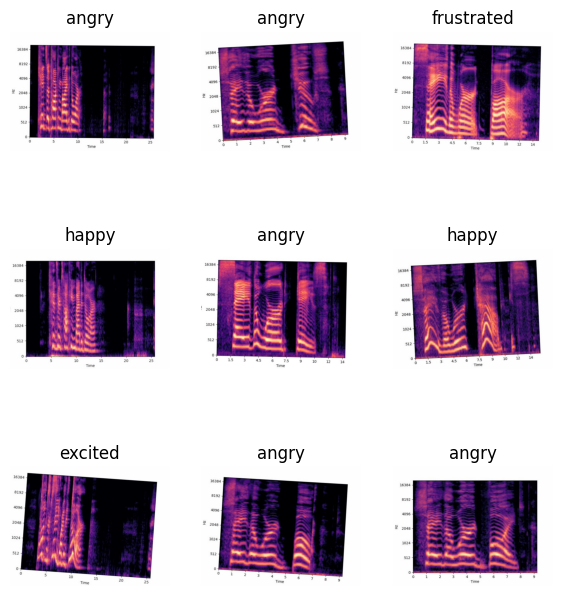

In [ ]:
data.show_batch(nrows=3, ncols=3, figsize=(7,8))

In [ ]:
# We reied using higher ResNet configurations, but it failed for all those due to INFRA restrictions.
learn = cnn_learner(data, models.resnet34, metrics=accuracy, lr=1e-4)

# One thing to note here is, we would be needding to save the model architecture
# and model weights separately. The model architecture may be requiring saving
# only once, while the weight would have to be saved after every training.


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 103MB/s]


In [ ]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Emotion-Recognition-Using-Sound",
    name="Emotion-Recognition-Training-Using-Ravedess-Tess-Alignedto-IEMOCAP-Classes-RESNET34",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "CNN",
    "dataset": "RAVDESS-TESS-IEMOCAP",
    "epochs": 5,
    }
)

wandb: Currently logged in as: raj8lm (mh_detection). Use `wandb login --relogin` to force relogin


#### if you want to fine-tune your model several times, you might want to run lr_find after each training cycle, as the lr you’ll need will be different (most likely lower). If you fine-tune a 2nd or 3rd time with the same lr as the 1st time, it’s not surprising to see the error rate go up, due a lr that is too high.

In [ ]:
from fastai.callback.tracker import SaveModelCallback

learn.fit_one_cycle(
    n_epoch=15,
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=True,
        monitor='accuracy',
        fname='emotion_detection_model_using_spectrogram_1st_iter'
        )
    )

epoch,train_loss,valid_loss,accuracy,time
0,2.982800,2.039111,0.240981,03:44
1,2.737879,1.683007,0.352092,01:09
2,2.298717,1.226167,0.513709,01:08
3,1.901759,0.970859,0.614719,01:09
4,1.603671,0.862382,0.665224,01:08
5,1.378157,0.778391,0.691198,01:08
6,1.239938,0.730900,0.708514,01:08
7,1.133062,0.697670,0.718615,01:09
8,1.062719,0.681088,0.722944,01:08
9,0.985537,0.666064,0.727273,01:08


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Better model found at epoch 0 with accuracy value: 0.24098123610019684.
Better model found at epoch 1 with accuracy value: 0.35209235548973083.
Better model found at epoch 2 with accuracy value: 0.5137085318565369.
Better model found at epoch 3 with accuracy value: 0.6147186160087585.
Better model found at epoch 4 with accuracy value: 0.6652236580848694.
Better model found at epoch 5 with accuracy value: 0.6911976933479309.
Better model found at epoch 6 with accuracy value: 0.7085137367248535.
Better model found at epoch 7 with accuracy value: 0.7186146974563599.
Better model found at epoch 8 with accuracy value: 0.7229437232017517.
Better model found at epoch 9 with accuracy value: 0.7272727489471436.
Better model found at epoch 10 with accuracy value: 0.7344877123832703.
Better model found at epoch 12 with accuracy value: 0.7359307408332825.
Better model found at epoch 14 with accuracy value: 0.7388167381286621.


In [ ]:
fastai_model = learn.model
# We need to do this only once
torch.save(fastai_model,f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/fastai_model_1st_iter_arch.pth") #model architecture

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_1st_iter.pth") # model weights

In [ ]:
fastai_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=9.120108734350652e-05)

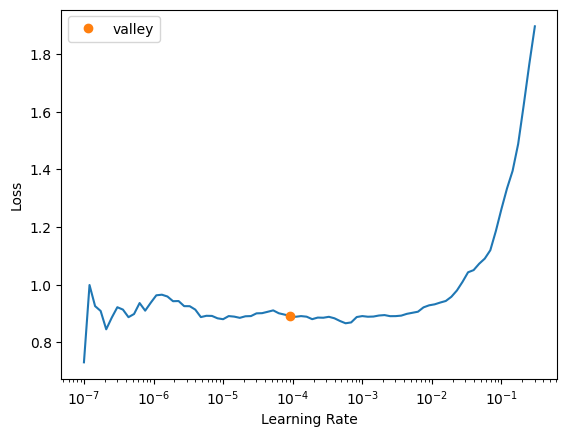

In [ ]:
learn.lr_find()

## 2nd Iteration Fine Tuning

In [ ]:
learn.fit_one_cycle(
    n_epoch=15,
    lr_max=slice(1e-5,1e-3),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=False,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_2nd_iter'
        )
    )

epoch,train_loss,valid_loss,accuracy,time
0,0.878892,0.635455,0.731602,01:27
1,0.780682,0.653479,0.773449,01:28
2,0.659398,0.614584,0.779221,01:27
3,0.560259,0.487318,0.815296,01:28
4,0.463023,0.449101,0.831169,01:27
5,0.373716,0.440579,0.842713,01:29
6,0.317178,0.380468,0.851371,01:27
7,0.257837,0.392744,0.874459,01:27
8,0.208492,0.498735,0.852814,01:28
9,0.186447,0.481661,0.844156,01:27


Better model found at epoch 0 with valid_loss value: 0.635455310344696.
Better model found at epoch 2 with valid_loss value: 0.6145843267440796.
Better model found at epoch 3 with valid_loss value: 0.48731788992881775.
Better model found at epoch 4 with valid_loss value: 0.4491007626056671.
Better model found at epoch 5 with valid_loss value: 0.44057875871658325.
Better model found at epoch 6 with valid_loss value: 0.38046810030937195.
Better model found at epoch 11 with valid_loss value: 0.3687558174133301.
Better model found at epoch 13 with valid_loss value: 0.36726289987564087.
Better model found at epoch 14 with valid_loss value: 0.35963723063468933.


SuggestedLRs(valley=3.981071586167673e-06)

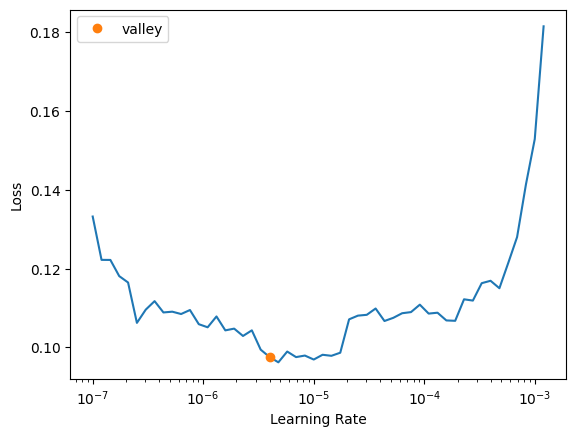

In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_2nd_iter.pth") # model weights

## 3rd Iteration Fine Tuning

In [ ]:
learn.fit_one_cycle(
    n_epoch=15,
    lr_max=slice(1e-5,1e-3),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=False,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_3rd_iter'
        )
    )


epoch,train_loss,valid_loss,accuracy,time
0,0.109864,0.349012,0.873016,01:27
1,0.115952,0.467885,0.865801,01:28
2,0.187204,0.557429,0.838384,01:27
3,0.217874,0.539305,0.849928,01:28
4,0.233085,0.555793,0.831169,01:27
5,0.194286,0.348327,0.854257,01:27
6,0.159415,0.396748,0.874459,01:28
7,0.144015,0.423133,0.867244,01:27
8,0.128131,0.371313,0.864358,01:29
9,0.116154,0.375601,0.870130,01:27


Better model found at epoch 0 with valid_loss value: 0.34901174902915955.
Better model found at epoch 5 with valid_loss value: 0.34832677245140076.
Better model found at epoch 10 with valid_loss value: 0.3126848638057709.
Better model found at epoch 12 with valid_loss value: 0.2932198941707611.


SuggestedLRs(valley=1.4454397387453355e-05)

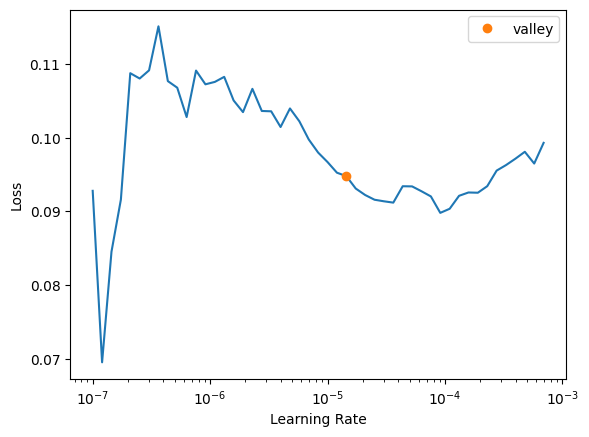

In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_3rd_iter.pth") # model weights

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    n_epoch=15,
    lr_max=slice(1e-5,1e-3),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=True,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_4th_iter'
        )
    )

epoch,train_loss,valid_loss,accuracy,time
0,0.099123,0.314507,0.875902,01:27
1,0.102442,0.282162,0.898990,01:27
2,0.123099,0.645754,0.825397,01:28
3,0.154134,0.383033,0.864358,01:28
4,0.151718,0.430626,0.852814,01:27
5,0.142895,0.434397,0.855700,01:29
6,0.123750,0.380002,0.874459,01:28
7,0.110161,0.361331,0.878788,01:27
8,0.106913,0.389318,0.875902,01:28
9,0.110393,0.376608,0.877345,01:27


Better model found at epoch 0 with valid_loss value: 0.3145066797733307.
Better model found at epoch 1 with valid_loss value: 0.282161682844162.
Better model found at epoch 10 with valid_loss value: 0.2814235985279083.


SuggestedLRs(valley=7.585775892948732e-05)

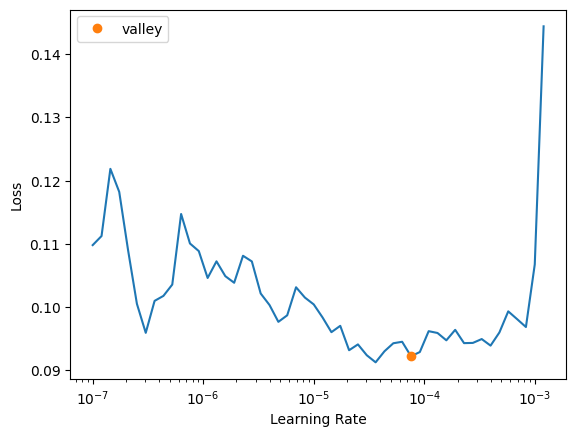

In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_4th_iter.pth") # model weights

## Using Transfer Learning

In [ ]:
np.random.seed(42)

data = ImageDataLoaders.from_folder(
    processed_data_path,
    train=".",
    valid_pct=0.2,
    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)],
    size=144,
    num_workers=4
    )
data.batch_size=25

In [ ]:
learn.data=data
data.train_ds[0][0].shape

(480, 640)

In [ ]:
data.vocab

['angry', 'excited', 'frustrated', 'happy', 'neutral', 'sad']

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    n_epoch=20,
    lr_max=slice(1e-5,1e-3),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=True,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_with_Transfer_Learning'
        )
    )

epoch,train_loss,valid_loss,accuracy,time
0,0.094160,0.300845,0.893218,01:28
1,0.091658,0.312999,0.884560,01:27
2,0.096293,0.372945,0.878788,01:27
3,0.129863,0.565494,0.847042,01:28
4,0.127742,0.468790,0.864358,01:27
5,0.128193,0.500478,0.854257,01:29
6,0.125474,0.544108,0.864358,01:28
7,0.127695,0.397098,0.874459,01:27
8,0.128009,0.298377,0.886003,01:28
9,0.115904,0.288523,0.904762,01:27


Better model found at epoch 0 with valid_loss value: 0.30084463953971863.
Better model found at epoch 8 with valid_loss value: 0.2983767092227936.
Better model found at epoch 9 with valid_loss value: 0.28852301836013794.
Better model found at epoch 13 with valid_loss value: 0.26427212357521057.
Better model found at epoch 14 with valid_loss value: 0.25880277156829834.
Better model found at epoch 15 with valid_loss value: 0.2580922245979309.
Better model found at epoch 16 with valid_loss value: 0.24209816753864288.


SuggestedLRs(valley=5.754399353463668e-06)

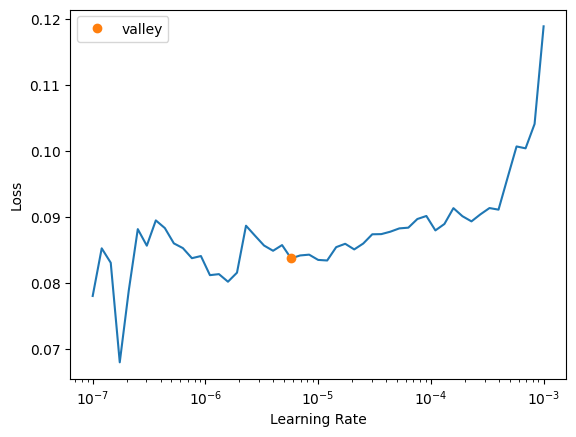

In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_1st_iter_With_Transfer_Learning.pth") # model weights

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    n_epoch=15,
    lr_max=slice(1e-5,1e-4),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=True,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_2nd_iter_With_Transfer_Learning'
        )
)

epoch,train_loss,valid_loss,accuracy,time
0,0.087253,0.241938,0.911977,01:28
1,0.086805,0.245093,0.904762,01:29
2,0.089911,0.256355,0.914863,01:27
3,0.090943,0.291854,0.907648,01:28
4,0.089112,0.326800,0.897547,01:28
5,0.089129,0.323421,0.897547,01:27
6,0.091429,0.345756,0.893218,01:28
7,0.091381,0.317977,0.904762,01:28
8,0.088592,0.291068,0.903319,01:27
9,0.089531,0.280967,0.904762,01:28


Better model found at epoch 0 with valid_loss value: 0.24193832278251648.


epoch,train_loss,valid_loss,accuracy,time
0,0.087253,0.241938,0.911977,01:28
1,0.086805,0.245093,0.904762,01:29
2,0.089911,0.256355,0.914863,01:27
3,0.090943,0.291854,0.907648,01:28
4,0.089112,0.326800,0.897547,01:28
5,0.089129,0.323421,0.897547,01:27
6,0.091429,0.345756,0.893218,01:28
7,0.091381,0.317977,0.904762,01:28
8,0.088592,0.291068,0.903319,01:27
9,0.089531,0.280967,0.904762,01:28


SuggestedLRs(valley=6.30957365501672e-05)

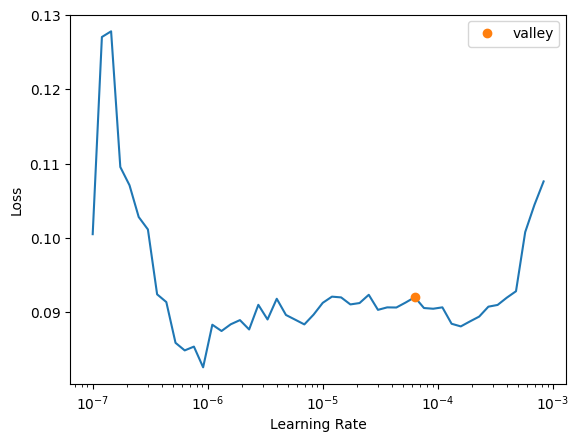

In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_2nd_iter_With_Transfer_Learning.pth") # model weights

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(
    n_epoch=15,
    lr_max=slice(1e-5,1e-3),
    cbs=SaveModelCallback(
        every_epoch=False,
        at_end=True,
        monitor='valid_loss',
        fname='emotion_detection_model_using_spectrogram_3rd_iter_with_Transfer_Learning'
        )
)

epoch,train_loss,valid_loss,accuracy,time
0,0.092210,0.266387,0.909091,01:27
1,0.093106,0.293837,0.906205,01:27
2,0.090267,0.437462,0.870130,01:27
3,0.135227,0.857895,0.841270,01:27
4,0.140210,0.394053,0.862915,01:28
5,0.125443,0.377858,0.881674,01:27
6,0.109857,0.310820,0.896104,01:27
7,0.102016,0.319147,0.894661,01:27
8,0.096332,0.320302,0.891775,01:28
9,0.092074,0.341700,0.891775,01:27


Better model found at epoch 0 with valid_loss value: 0.26638659834861755.


In [ ]:
learn.lr_find()

In [ ]:
## If the value of lr_find() is giving better results than the previous iteration, then save this model
# Saving the models best state-dict during the epochs
fastai_model = learn.model

# We need to this everytime we train our model
torch.save(fastai_model.state_dict(), f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_3rd_iter_With_Transfer_Learning.pth") # model weights

In [ ]:
learn.path

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


SuggestedLRs(valley=1.737800812406931e-05)

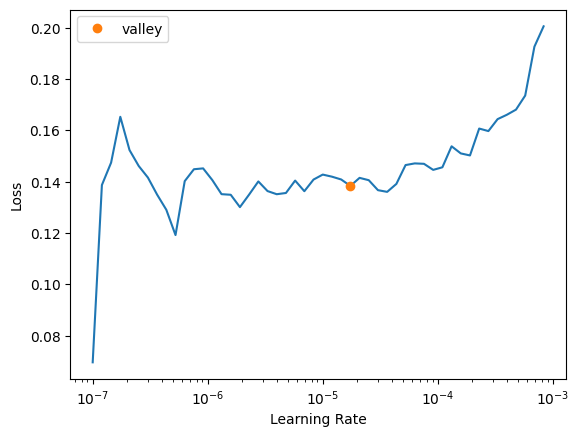

In [ ]:
saved_learn = learn.load(f'{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_3rd_iter_With_Transfer_Learning')
saved_learn.lr_find()

In [ ]:
saved_learn.model

In [ ]:
def memory_stats():
    print(torch.cuda.memory_allocated()/1024**2)
    print(torch.cuda.memory_cached()/1024**2)


def allocate():
    x = torch.randn(1024*1024, device='cuda')
    memory_stats()

memory_stats()
torch.cuda.empty_cache()
memory_stats()

In [ ]:
# Make a prediction
image_dir = f'{PROCESSED_DATA_PATH}/frustrated/'
image_path = f"{image_dir}/03-01-07-01-01-01-04.wav.jpeg"
pred_class, pred_idx, outputs = saved_learn.predict(load_image(image_path))
pred_class, pred_idx, outputs

('frustrated',
 tensor(2),
 tensor([7.9657e-07, 1.0403e-09, 1.0000e+00, 1.6777e-08, 8.6831e-10, 1.3504e-07]))

('frustrated',
 tensor(2),
 tensor([7.9657e-07, 1.0403e-09, 1.0000e+00, 1.6777e-08, 8.6831e-10, 1.3504e-07]))

### ABOVE setup is all about preparing the CNN model with RAVDESS and TESS Datasets and training the model

#### Now we are going to do the following the items:
1. Process the IEMOCAP dataset and convert the audio files to spectrogram images. [DONE]
2. Train the above model with IEMOCAP data and the same training data would be used to Train SKAIG model.

The results of Spectrogram prediction woud be added to the prediction results of SKAIG. We will do SOFTMAX on top of the final result which will give us the final emotion of an utterance.

There are couple of EMOTIONS which are not present in RAVDESS or TESS. Those folders will get copied to Processed_data for training so that those emotions are present from beginning.
This are the folders which need to be added in the Processed_Data folder:
* excited
* frustrated


In [ ]:
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

### TRYING TO SEE IF WE CAN USE PYTORCH TO LOAD THIS MODEL

In [ ]:
import torch
import torch.nn as nn
from fastai.vision.models import resnet34
from fastai.vision.all import *
from fastai.vision.all import PILImage, tensor


class CustomModel(nn.Module):
    def __init__(self, pretrained_model_path):
        super(CustomModel, self).__init__()

        model_arch_path = f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/fastai_model_1st_iter_arch.pth"
        base_model = torch.load(model_arch_path) #load model architecutre
        # base_model = resnet34()

        base_model.load_state_dict(torch.load(pretrained_model_path))

        # Freeze all layers
        for param in base_model.parameters():
            param.requires_grad = False

        # Concatenate the base model with the new layer
        self.base_model = base_model
        # Replace the last layer with the new layer
        self.model = nn.Sequential(self.base_model)


    def forward(self, x):
        # Convert JPEG file path to tensor
        image = PILImage.create(x)
        tensor_image = tensor(image)
        # Normalize image tensor
        normalized_image = tensor_image / 255.0
        # Add batch dimension
        normalized_image = normalized_image.unsqueeze(0)
        # Transpose to [batch_size, channels, height, width] as we were getting channel mismatch error
        normalized_image = normalized_image.permute(0, 3, 1, 2)

        # Move input tensor to GPU if available
        if torch.cuda.is_available():
            device = torch.device("cuda")
            normalized_image = normalized_image.to(device)
            self.to(device)

        print(normalized_image.shape)
        # Pass the normalized image through the base model
        logits = self.model(normalized_image)

        print(f"LOGITS: {logits}")
        return logits


In [ ]:
from fastai.vision.all import PILImage, tensor

# Path to the pretrained fastai model
pretrained_model_path = f"{DATA_ROOT_PATH}/saved_models/emotion_detection_using_only_sound/emotion_detection_state_dict_using_spectrogram_2nd_iter.pth"

# Create an instance of the custom model
model = CustomModel(pretrained_model_path)

# Path to your image file - HAPPY
input_jpeg_path = '/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/happy/03-01-03-01-01-01-11.wav.jpeg'

# PATH Image File - ANGRY
# input_jpeg_path = '/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/angry/03-01-05-01-01-01-10.wav.jpeg'

# PATH Image File - NEUTRAL
# input_jpeg_path = '/content/drive/MyDrive/emotion_detection_using_sound/data/processed_data_ravdess_tess/neutral/03-01-01-01-01-01-03.wav.jpeg'

# Example usage with a JPEG file
model.eval()
logits = model(input_jpeg_path)

# Applying softmax to convert logits to probabilities
probabilities = F.softmax(logits, dim=1)

# Getting the predicted class (class with the highest probability)
predicted_class = torch.argmax(probabilities, dim=1)

# Getting the probability of the predicted class
predicted_probability = probabilities[0, predicted_class]

emotion_class_indices = {
    0: 'angry',
    1: 'excited',
    2: 'frustrated',
    3: 'happy',
    4: 'neutral',
    5: 'sad'
}

# Print the predicted class and probability
print("Logits:", logits)
print("Probabilities:", probabilities)
print("Predicted Class:", predicted_class.item())
print("Predicted Class:", emotion_class_indices[predicted_class.item()])
print("Predicted Probability:", predicted_probability.item())

torch.Size([1, 3, 480, 640])
LOGITS: tensor([[-7.7254,  0.0435, -1.6553, -5.0533,  7.7370,  5.1196]],
       device='cuda:0')
Logits: tensor([[-7.7254,  0.0435, -1.6553, -5.0533,  7.7370,  5.1196]],
       device='cuda:0')
Probabilities: tensor([[1.7945e-07, 4.2454e-04, 7.7655e-05, 2.5967e-06, 9.3150e-01, 6.7990e-02]],
       device='cuda:0')
Predicted Class: 4
Predicted Class: neutral
Predicted Probability: 0.9315048456192017
